## Computing tune footprint  (MADX version)

In [40]:
# https://github.com/MethodicalAcceleratorDesign/madx-examples/blob/07f2276c149e8ea34ea0d5699829d42ec295f402/foot/footprint.mad#L597

# The goal is to transform the following fucntion it a pythonic one 
# I would suggest considering to pass the initial conditions as an argument and to split the tracking from the FFT computing.
# You can proceed by steps.
import sys
import pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import time

# Importing pymask
sys.path.append('../../../lhcmask')
import pymask as pm

In [41]:


# Starting Madx
myFile = 'run3_thin_beta_36.save'
mad = pm.Madxp(command_log = "tmp_my_log.log")
mad.option(echo = False, warn = False)
mad.call(file = myFile)
#mad.option(echo = True, warn = True)
for my_sequence in ['lhcb1', 'lhcb2']:
    mad.use(sequence = my_sequence)
    mad.twiss(table = f'{my_sequence}_twiss')     
    
# MADX implementation to get the tune, using dynap
def compute_tune_fooprint(self):
    self.input('''
    option,trace;
    small=0.05;
    big=sqrt(1.-small^2);
    track,dump, onetable = true;
    xs=small; ys=small;
    value,xs,ys;
    start,fx=xs,fy=ys;  // zero amplitude
    nsigmax=6;
    n=1; // sigma multiplier
    m=0; // angle multiplier
    while (n <= nsigmax)
    {
      angle = 15*m*pi/180;
      if (m == 0) {xs=n*big; ys=n*small;}
      elseif (m == 6) {xs=n*small; ys=n*big;}
      else
      {
        xs=n*cos(angle);
        ys=n*sin(angle);
      }
      value,xs,ys;
      start,fx=xs,fy=ys;
      m=m+1;
      if (m == 7) { m=0; n=n+1;}
    };
    ! you should run only not dynap
    run,turns=1024;
    dynap,fastune,turns=1024;
    endtrack;  
    ''')


# Tracking and computing tune:
#-------------------------------------
startTime = time.time()

pm.Madxp.compute_tune_fooprint = compute_tune_fooprint
mad.compute_tune_fooprint()

print('ELAPSED TIME : ',time.time()-startTime,' s')


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.03 21:26:12      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   7.013551E-08 deltap:   0.000000E+00
orbit:   6.947375E-08 -1.044533E-09  6.087062E-08  8.200428E-10  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
        26658.8832                 -0    0.0003480925606        53.59849919 

                q1                dq1            betxmax              dxmax 
       62.30997944         1.48742115         6742.13218        3.257730186 

             dxrms             xcomax             xcorms                 q2 
       1.406323763       0.0121563694     0.001932720389        60.31993712 

               dq2            betymax              dymax 

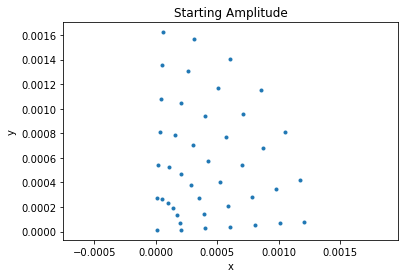

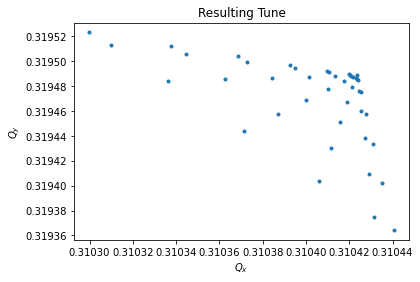

In [44]:
#-------------------------------------
# Showing Results

trackedMADX = mad.table['trackone'].dframe()
plt.figure()
plt.title('Starting Amplitude')
plt.plot(trackedMADX.groupby('turn').get_group(0)['x'],trackedMADX.groupby('turn').get_group(0)['y'],'.')
plt.axis('equal')
plt.xlabel('x')
plt.ylabel('y')

dynapMADX = mad.table['dynaptune'].dframe()
plt.figure()
plt.title('Resulting Tune')
plt.plot(dynapMADX['tunx'],dynapMADX['tuny'],'.')
plt.xlabel(r'$Q_x$')
plt.ylabel(r'$Q_y$')

plt.show()

# Pythonic way

### New tracking functions:

In [36]:
# Importing pymask

import sys
sys.path.append('../../../lhcmask')
import pymask as pm

In [37]:
pm.madxp.Madxp.track?

In [6]:
pm.madxp.Madxp.track_stringCmd?

In [7]:
pm.madxp.get_tracking_string?

### New footprint functions:

In [2]:
pm.footprint.generate_coordGrid?

In [3]:
pm.footprint.getTune_pynaff?

In [ ]:
pm.footprint.getTune_fft?

In [4]:
pm.footprint.compute_tunes?

## Example 1 : direct comparison with MADX approach

In [5]:
# Taking same starting coordinates as in the MadX example:
#---------------------
coordinates = trackedMADX.groupby('turn').get_group(0)
display(coordinates.head())

,number,turn,x,px,y,py,t,pt,s,e
#e,1.0,0.0,0.000010,1.905760e-07,0.000014,-1.636308e-07,0.0,0.0,0.0,0.0
#e,2.0,0.0,0.000202,3.806715e-06,0.000014,-1.635981e-07,0.0,0.0,0.0,0.0
#e,3.0,0.0,0.000195,3.681618e-06,0.000070,-8.469910e-07,0.0,0.0,0.0,0.0
#e,4.0,0.0,0.000175,3.300859e-06,0.000135,-1.636295e-06,0.0,0.0,0.0,0.0
#e,5.0,0.0,0.000143,2.695152e-06,0.000191,-2.314089e-06,0.0,0.0,0.0,0.0


In [12]:

import pymask.footprint as footprint

# Starting Madx
#-------------------
myFile = 'run3_thin_beta_36.save'
mad = pm.Madxp(command_log = "tmp_my_log.log")
mad.option(echo = False, warn = False)
mad.call(file = myFile)
#mad.option(echo = True, warn = True)
for my_sequence in ['lhcb1', 'lhcb2']:
    mad.use(sequence = my_sequence)
    mad.twiss(table = f'{my_sequence}_twiss')  

# Taking same starting coordinates as in the MadX example:
#---------------------
coordinates = trackedMADX.groupby('turn').get_group(0)


# TRACKING THE PARTICLES WITH MADX:
#---------------------
startTime = time.time()

trackedPython = mad.track(coordinates,NTurns=1024,filename='./tmp_tracking.madx')

# Computing the tune:
#---------------------    
dynapPython = footprint.compute_tunes(trackedPython,method='pynaff')

print('ELAPSED TIME : ',time.time()-startTime,' s')
if np.all(trackedPython == trackedMADX): print('ALL GOOD!')

    
    


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.03 19:51:39      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   7.013551E-08 deltap:   0.000000E+00
orbit:   6.947375E-08 -1.044533E-09  6.087062E-08  8.200428E-10  0.000000E+00  0.000000E+00
++++++ warning: TWCPIN:  One-turn map R symplectic deviation:  0.170920E-11 (symplectifying R)                                                                                                               

++++++ table: summ

            length             orbit5               alfa            gammatr 
        26658.8832                 -0    0.0003480925606        53.59849919 

                q1                dq1            betxmax              dxmax 
       62.30997944         1.48742115         6742.13218        3.257730186 

      

ELAPSED TIME :  54.60833954811096  s
ALL GOOD!


### Comparing the tune obtained with dynap

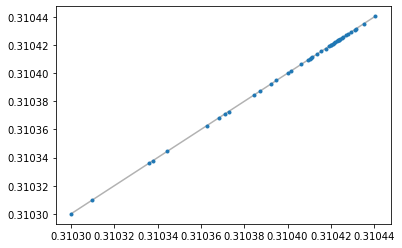

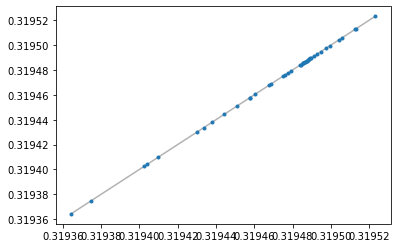

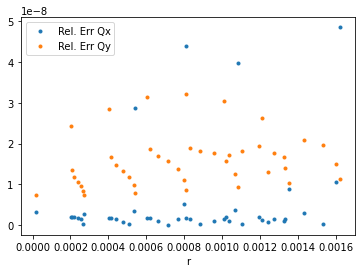

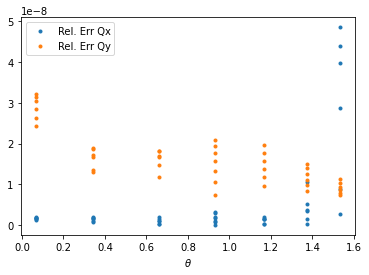

In [38]:
plt.figure()
plt.plot(np.array(dynapPython['Qx']) ,np.array(dynapMADX['tunx']),'.')
plt.plot([np.min(dynapPython['Qx']),np.max(dynapPython['Qx'])],[np.min(dynapPython['Qx']),np.max(dynapPython['Qx'])],'k',alpha=0.3,zorder=-10)

plt.figure()
plt.plot(np.array(dynapPython['Qy']) ,np.array(dynapMADX['tuny']),'.')
plt.plot([np.min(dynapPython['Qy']),np.max(dynapPython['Qy'])],[np.min(dynapPython['Qy']),np.max(dynapPython['Qy'])],'k',alpha=0.3,zorder=-10)
plt.show()

coordinates = trackedMADX.groupby('turn').get_group(0)
rPos = np.sqrt(np.array(coordinates['x']**2 + coordinates['y']**2))
thetaPos = np.arctan(np.array(coordinates['y'])/np.array(coordinates['x']))

plt.figure()
plt.plot(rPos,np.abs(np.array(dynapMADX['tunx'])-dynapPython['Qx'])/np.array(dynapMADX['tunx']),'.',label = 'Rel. Err Qx')
plt.plot(rPos,np.abs(np.array(dynapMADX['tuny'])-dynapPython['Qy'])/np.array(dynapMADX['tuny']),'.',label = 'Rel. Err Qy')
plt.legend()
plt.xlabel('r')
plt.show()

plt.figure()
plt.plot(thetaPos,np.abs(np.array(dynapMADX['tunx'])-dynapPython['Qx'])/np.array(dynapMADX['tunx']),'.',label = 'Rel. Err Qx')
plt.plot(thetaPos,np.abs(np.array(dynapMADX['tuny'])-dynapPython['Qy'])/np.array(dynapMADX['tuny']),'.',label = 'Rel. Err Qy')
plt.legend()
plt.xlabel(r'$\theta$')
plt.show()

## Example 2: Generating our own coordinates DF

,fy,fx,r,theta
0,0.000785,0.049994,0.050000,0.015708
1,0.011170,0.711023,0.711111,0.015708
2,0.021554,1.372053,1.372222,0.015708
3,0.031938,2.033082,2.033333,0.015708
4,0.042322,2.694112,2.694444,0.015708


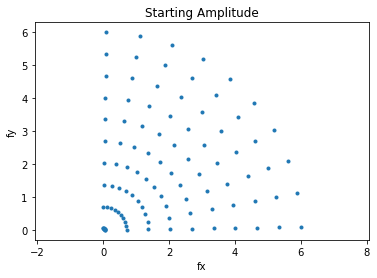

In [43]:
coordinates = footprint.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r','theta'],nPoints=100)

coordinates.insert(0,'fx',coordinates['r']*np.cos(coordinates['theta']))
coordinates.insert(0,'fy',coordinates['r']*np.sin(coordinates['theta']))

display(coordinates.head())

plt.figure()
plt.title('Starting Amplitude')
plt.plot(coordinates['fx'],coordinates['fy'],'.')
plt.xlabel('fx');
plt.ylabel('fy');
plt.axis('equal');

## Example 3 : Comparing execution time (file vs string input)

In [35]:

# Starting Madx
#---------------------
myFile = 'run3_thin_beta_36.save'
mad = pm.Madxp(command_log = "tmp_my_log.log")
mad.option(echo = False, warn = False)
mad.call(file = myFile)
#mad.option(echo = True, warn = True)
for my_sequence in ['lhcb1', 'lhcb2']:
    mad.use(sequence = my_sequence)
    mad.twiss(table = f'{my_sequence}_twiss')  


# GENERATING THE INITIAL COORDINATES OF THE PARTICLES:
#---------------------
NParticles = 500
coordinates = footprint.generate_coordGrid([0.05,6],[0.01*np.pi/2,0.99*np.pi/2],labels = ['r','theta'],nPoints=NParticles)
coordinates.insert(0,'fx',coordinates['r']*np.cos(coordinates['theta']))
coordinates.insert(0,'fy',coordinates['r']*np.sin(coordinates['theta']))

# TRACKING THE PARTICLES WITH MADX:
#---------------------
startTime = time.time()
trackedPython = mad.track(coordinates,NTurns=1024,filename='./tmp_tracking.madx')
fileTime = time.time()-startTime

startTime = time.time()
trackedPython = mad.track_stringCmd(coordinates,NTurns=1024)
stringTime = time.time()-startTime


print(f"{len(coordinates)} Particles tracked.\nFile mode : {fileTime} s\nString mode : {stringTime} s")


  ++++++++++++++++++++++++++++++++++++++++++++
  +     MAD-X 5.06.01  (64 bit, Linux)       +
  + Support: mad@cern.ch, http://cern.ch/mad +
  + Release   date: 2020.09.01               +
  + Execution date: 2021.03.03 20:04:10      +
  ++++++++++++++++++++++++++++++++++++++++++++
enter Twiss module
  
iteration:   1 error:   7.013551E-08 deltap:   0.000000E+00
orbit:   6.947375E-08 -1.044533E-09  6.087062E-08  8.200428E-10  0.000000E+00  0.000000E+00

++++++ table: summ

            length             orbit5               alfa            gammatr 
        26658.8832                 -0    0.0003480925606        53.59849919 

                q1                dq1            betxmax              dxmax 
       62.30997944         1.48742115         6742.13218        3.257730186 

             dxrms             xcomax             xcorms                 q2 
       1.406323763       0.0121563694     0.001932720389        60.31993712 

               dq2            betymax              dymax 

enter TRACK module
  
iteration:   1 error:   9.167865E-08 deltap:   0.000000E+00
orbit:  -6.888587E-09 -2.283454E-10 -6.630723E-08  7.874107E-10  0.000000E+00  0.000000E+00

Full 6D closed orbit search.
Initial value of 6-D closed orbit from Twiss: 
orbit0  -6.888587E-09 -2.283454E-10 -6.630723E-08  7.874107E-10  0.000000E+00  0.000000E+00
  Singular matrix occurred during closed orbit search.

6D closed orbit found by subroutine trclor 
iteration:   2 error:   1.345836E-05 deltap:   0.000000E+00
orbit:  -6.888587E-09 -2.283454E-10 -6.630723E-08  7.874107E-10  0.000000E+00  0.000000E+00

++++++ table: tracksumm

    number       turn                  x                 px 
         1          0    1.009040798e-05    1.905505316e-07 
         2          0    6.726938654e-05    1.270336877e-06 
         3          0    0.0001244483651    2.350123222e-06 
         4          0    0.0001816273436    3.429909568e-06 
         5          0    0.0002388063222    4.509695913e-06 
         6   

484 Particles tracked.
File mode : 325.25934529304504 s
String mode : 309.9293918609619 s


## Example 4 : Showing spectrum of x(t), y(t)

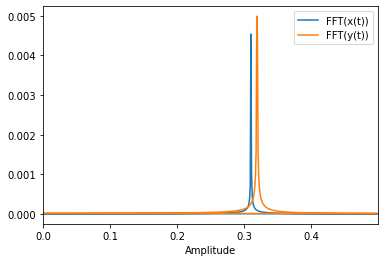

Qx    0.310244
Qy    0.319024
dtype: float64

In [13]:

# Extracting tracking data of a single particle:
particleNumber = 1
singleParticle = trackedPython.groupby('number').get_group(particleNumber)

# Showing the spectrum:
footprint.getTune_fft(singleParticle,showSpectrum=True)